<a href="https://colab.research.google.com/github/guiaustregesilo-ds/Loyalty-Program-with-Clustering/blob/main/c02_gca_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **High Value Customer Identification**

## PLANNING IoT

### Input

**1 - Business Problem**:
  - Selecting the most valuable customers to be included in a loyalty program.

**2 - Dataset**
  - Online e-commerce sales over a one-year period.

### Output

**1 -  Identifying the participants for the "Royalty" program."**
  - Lista: client_id | id_royalty
            1234     | yes/R
            4567     | no/R

**2 - Business Questions Report: Royalty Program**

    - 1. Who are the people eligible to participate in the program?"

    - 2.  How many customers will be in the group?

    - 3. What are the main characteristics of these customers?

    - 4. What is the revenue contribution of the selected customers?

    - 5. What is the expected revenue for this group in the coming months?

    - 6. & 7. What are the conditions for a person to be eligible (or not)?

    - 8. How can we prove the program is better than the rest of the base?

    - 9. What actions can the marketing team take to increase revenue?

### Tasks

- **Who are the people eligible to participate in the "Royalty" program?**

    - What does it mean to be eligible? What are "high-value" customers?

    - Revenue ?
        - High Average Order Value (AOV);
        - High Lifetime Value (LTV);
        - Low Recency;
        - High Basket Size;
        - Low Churn probability;
        - High predicted LTV;
        - High purchase propensity.

    - Cost ?
        - Low return rate;

    - Shopping experience ?
        - High average rating.

- **2. How many customers will be part of the group?**
    - Total number of customers;
    - Percentage of the filtered group.

- **3. What are the main characteristics of these customers?**
    - List customer characteristics:
        - Age;
        - Location;
    - Purchasing behavior characteristics:
        - Clustering attributes.

- **4. What is the revenue contribution percentage of the selected customers for "Royalty"**
    -  Total annual revenue;
    -  Total revenue of the "Loyalty" group.

- **5. What is the expected revenue for this group in the coming months?**
    -  LTV of the "Loyalty" group;
    -  Cohort analysis.

- **6. What are the conditions for a person to be eligible for "Royalty"**
    -  Define the frequency {1 month, 3 months};
    -  The person needs to be similar to those in the loyalty group.

- **7. What are the conditions for a person not to be eligible for "Royalty":**
    -  Define the frequency {1 month, 3 months};
    -  The person needs to be dissimilar from those in the loyalty group.

- **8. How can we prove the "Royalty" program is more effective than the rest of the customer base?**
    -  A/B Testing;
    -  Bayesian A/B Testing;
    -  Hypothesis Testing.

- **9. Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    -  Discount;
    -  Exclusive access to products;
    -  Free shipping or a shipping discount;
    -  Company visit.

## 1.0 Benchmark Solutions

### 1.1 Desk Research


# 0.0 IMPORTS

In [2]:
import pandas                            as pd
import numpy                             as np

import umap.umap_                        as umap

import seaborn                           as sns

from google.colab         import drive
drive.mount('/content/drive')

from matplotlib           import pyplot  as plt
from plotly               import express as px

from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.cluster      import KMeans
from sklearn              import cluster as c
from sklearn              import metrics as m


from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer

Mounted at /content/drive


## 0.1 HELPER FUNCTIONS

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [29, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

## 0.2 LOAD DATASET

In [4]:
# load data
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Programa de Fidelidade com Clusterização/data/Ecommerce.csv', encoding='ISO-8859-1')

# drop extra column
df_raw = df_raw.drop(columns='Unnamed: 8', axis=1)

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [7]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 DATA DIMENSION

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 DATA TYPES

In [9]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,float64
customer_id,float64
country,object


## 1.4 CHECK NA'S

In [10]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,1454
quantity,0
invoice_date,0
unit_price,0
customer_id,135080
country,0


## 1.5 FILLOUT NA'S

In [11]:
# remove nas
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:2f}'.format(1 - (df1.shape[0] / df_raw.shape[0])))

Removed data: 0.249267


In [12]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


## 1.6 CHANGE TYPES

In [13]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,float64
customer_id,float64
country,object


In [14]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 DESCRIPTIVE STATISTICS

# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1 FEATURE CREATION

In [16]:
df2.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [17]:
# data reference
df2_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity',
                    'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

# gross revenue
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df2_ref = pd.merge(df2_ref, df_monetary, on='customer_id', how='left')

# recency - last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df2_ref = pd.merge(df2_ref, df_recency, on='customer_id', how='left')

# frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df2_ref = pd.merge(df2_ref, df_freq, on='customer_id', how='left')

# AVG Ticket
df2_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df2_ref = pd.merge(df2_ref, df2_avg_ticket, on='customer_id', how='left')


In [18]:
df2_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 3.0 FEATURE SELECTION

In [19]:
df3 = df2_ref.copy()

# 4.0 EXPLORATORY DATA ANALYSIS

In [20]:
df4 = df3.copy()

# 5.0 DATA PREPARATION

In [21]:
df5 = df4.copy()

# 6.0 FEATURE SELECTION

In [22]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE-TUNNING

In [23]:
X = df6.drop(columns='customer_id')

In [24]:
cluster = [2, 3, 4, 5, 6, 7]

## 7.1 WITHIN-CLUSTER SUM OF SQUARE ( WSS )

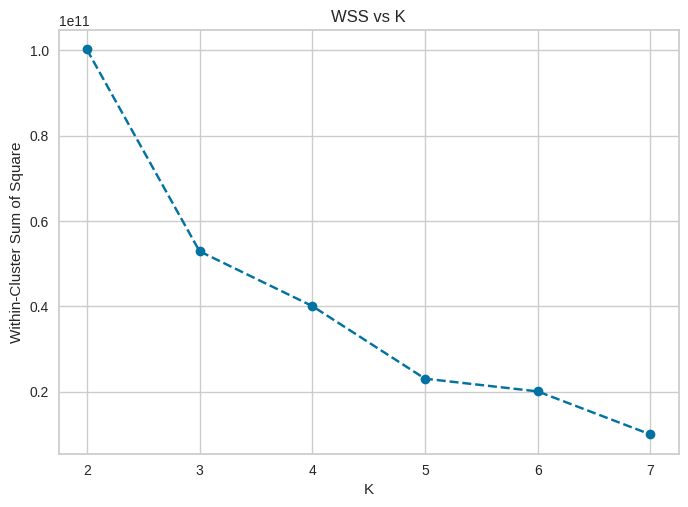

In [25]:
wss = []
for k in cluster:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Methods
plt.plot(cluster, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

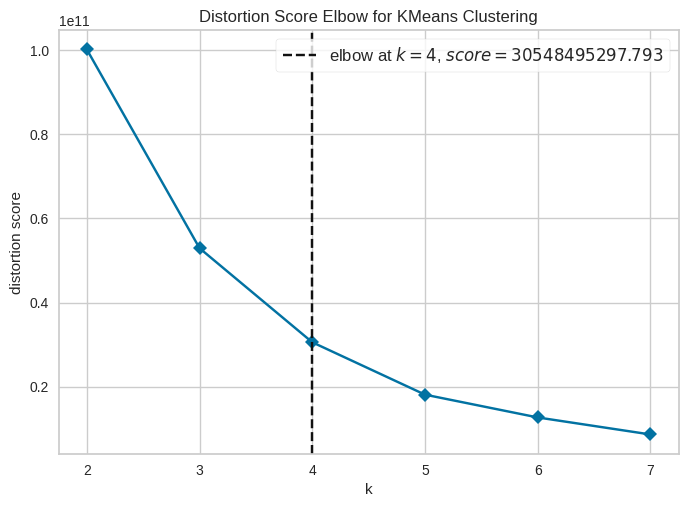

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
kmeans = KElbowVisualizer(KMeans(), k=cluster, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 SILLHOUETTE SCORE

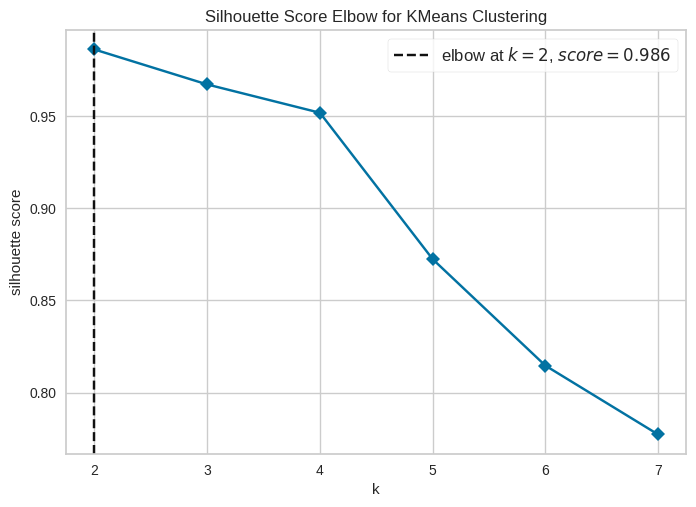

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [27]:
kmeans = KElbowVisualizer(KMeans(), k=cluster, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

### 7.2.1 SILHOUETTE ANALYSIS

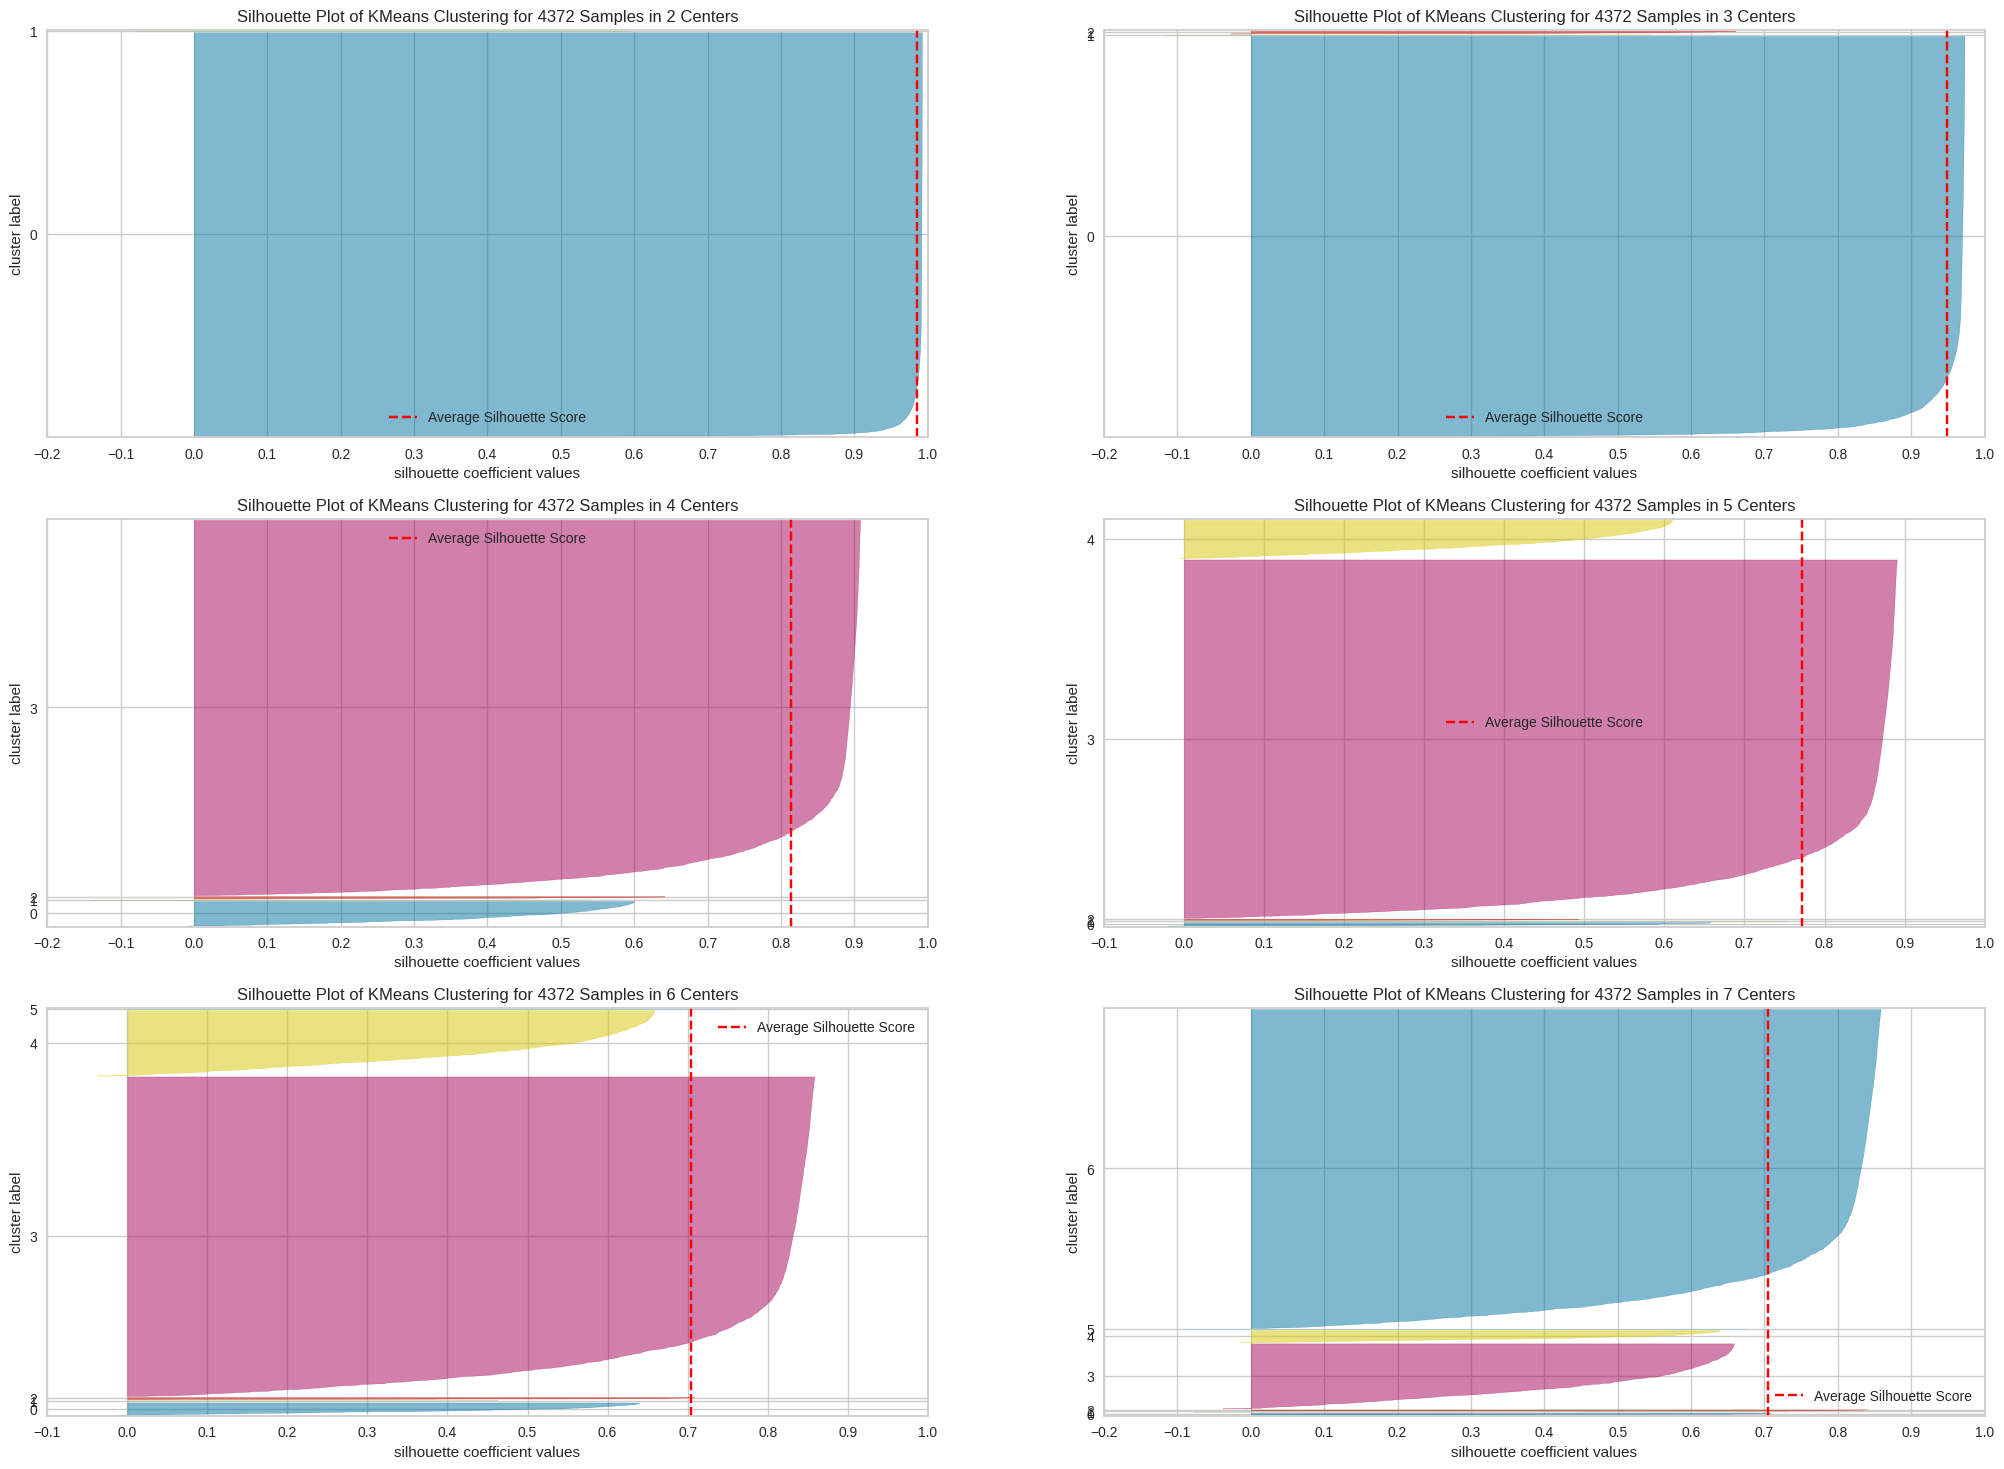

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in cluster:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax = ax[q -1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [29]:
# model definition
k = 4
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 CLUSTER VALIDATION

In [30]:
# WSS - WITHIN-CLUSTER SUM OF SQUARE
print('WSS value: {}'.format(kmeans.inertia_))

## SS - SILHOUETTE SCORE
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40056506734.60232
SS value: 0.8139972028952444


# 9.0 CLUSTER ANALYSIS

In [31]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


## 9.1 VISUALIZATION INSPECTION

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


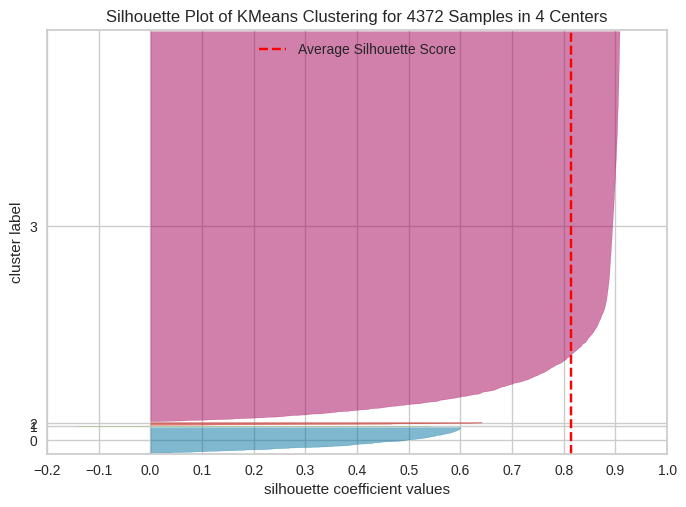

In [32]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.1.1 - 2d Plot

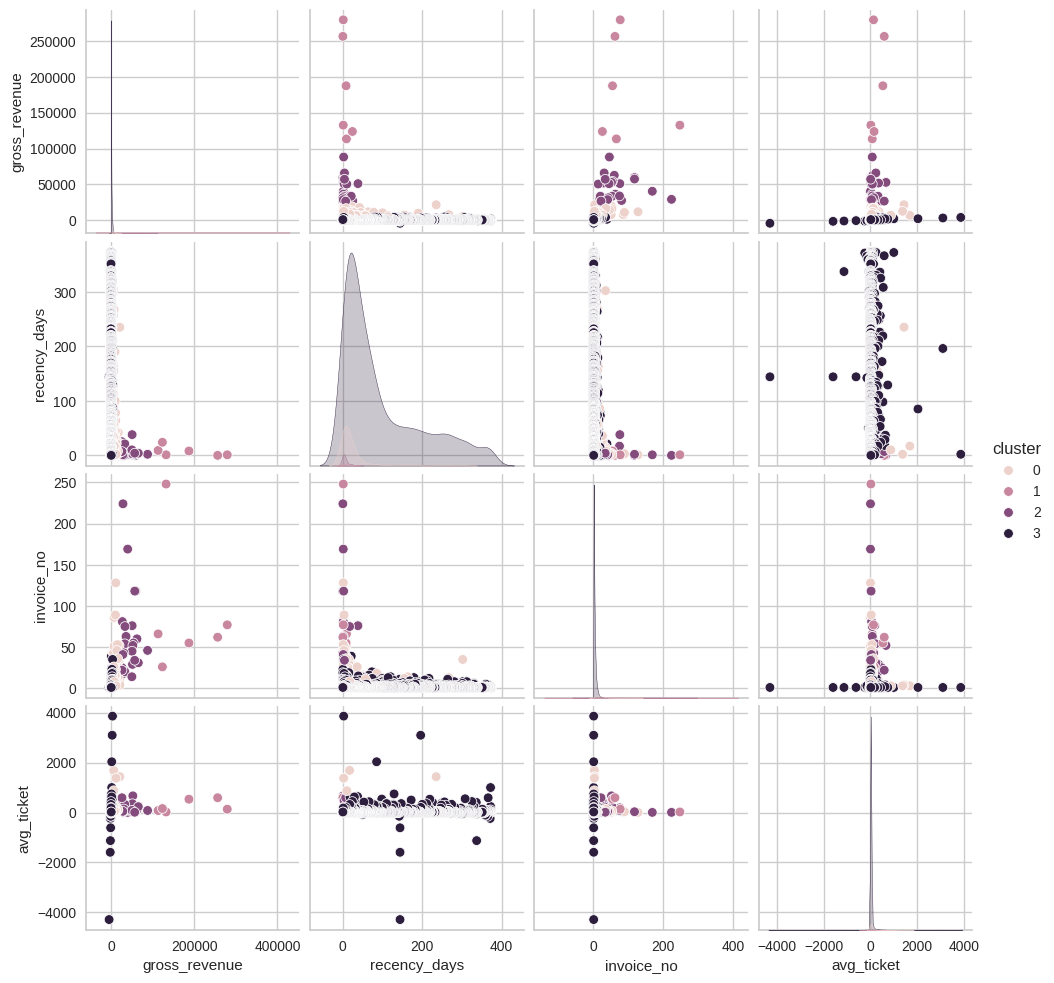

In [33]:
# 2d Plot
df9_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df9_viz, hue='cluster')

### 9.1.2 UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

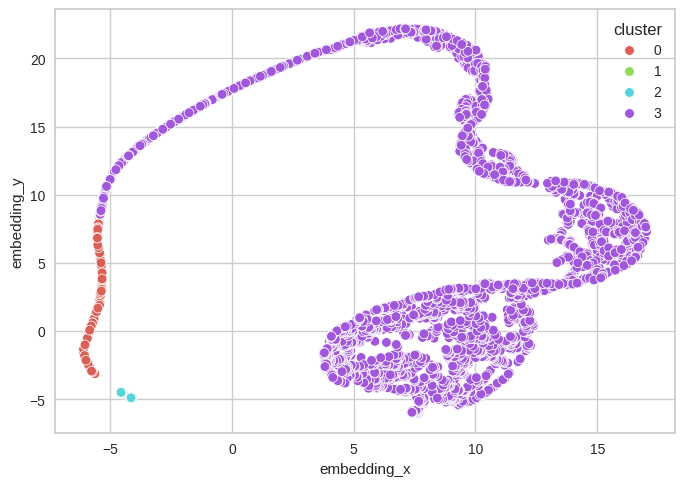

In [34]:
reducer = umap.UMAP( n_neighbors=20 ,random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df9_viz['embedding_x'] = embedding[:, 0]
df9_viz['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(
    x='embedding_x',
    y='embedding_y',
    hue='cluster',
    palette=sns.color_palette('hls', n_colors=df9_viz['cluster'].nunique()),
    data=df9_viz
)


In [35]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2 CLUSTER PROFILE

In [36]:
# number of customer
df9_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df9_cluster['perc_customer'] = 100 * (df9_cluster['customer_id'] / df9_cluster['customer_id'].sum())

# AVG Gros revenue
df9_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_avg_gross_revenue, on='cluster', how='inner')

# AVG - recency days
df9_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_avg_recency_days, on='cluster', how='inner')

# AVG - invoice_no
df9_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_avg_invoice_no, on='cluster', how='inner')

# AVG - Ticket
df9_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_ticket, on='cluster', how='inner')

df9_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,267,6.107045,8089.028652,20.280899,19.528090,62.783157
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.969295,3.641120,25.359654


## Cluster 01: Probably Royalty
- Number of Customers: 6 ( 0.14% of Customers )
- AVG Recency: 7 days
- AVG Invoice: 89
- AVG Revenue: $ 182.182,00

## Cluster 02:
- Number of Customers: 31 ( 0.71% of Customers )
- AVG Recency: 14 days
- AVG Invoice: 53
- AVG Revenue: $ 40.543,52

## Cluster 03:
- Number of Customers: 4.335 ( 99% of Customers )
- AVG Recency: 92 days
- AVG Invoice: 5
- AVG Revenue: $ 1.372,57

# 10.0 DEPLOY TO PRODUCTION